# Bi-Est-Python
>Semi-supervised modeling of mixture of mixtures of multivariate gaussians

Given an unbiased unlabeled sample and labeled biased positive and negative samples, estiamte the distributions of the three samples. The biased positive and negative distributions are assumed to share the same components of the unbiased positive and negative distributions but with different component mixture weights as discussed in [1]. Support has been added for handling noisy positive and negative biased samples by providing score estimates for the instances that approximate the posterior. Additionally, one can choose whether to assing equal importance to each instance or each sample.

## Installation
`pip install bi_est_python`


[1]De Paolis Kaluza, M. Clara, Shantanu Jain, and Predrag Radivojac. "An Approach to Identifying and Quantifying Bias in Biomedical Data." PACIFIC SYMPOSIUM ON BIOCOMPUTING 2023: Kohala Coast, Hawaii, USA, 3–7 January 2023. 2022.

In [1]:
import numpy as np
from collections import namedtuple
import seaborn as sns
import matplotlib.pyplot as plt

from bi_est_python.pnu_em import PNU_EM
from bi_est_python.Mixture import NMixture, PUMixture

In [12]:
# Create a dummy dataset
rng = np.random.default_rng()
num_components = 2
dim = 2
N_labeled_pos = N_labeled_neg = 5000
N_unlabeled = 10000
Params = namedtuple('params', ['mu_pos', 'mu_neg', 'sigma', 'w_pos', 'w_neg', 'alpha', 'v_pos', 'v_neg'])
params = Params(alpha = 0.3,
                mu_pos = np.array([[-4] * dim,
                                    [-8] * dim]),
                mu_neg = np.array([[4] * dim,
                                    [8] * dim]),
                sigma = np.tile(np.eye(dim), (num_components,1,1)),
                w_pos = np.array([0.75, 0.25]),
                v_pos=np.array([0.2, 0.8]),
                w_neg = np.array([0.35, 0.65]),
                v_neg=np.array([0.5, 0.5]))

# positive Gaussian mixtures

pos = NMixture(mu=params.mu_pos, sigma=params.sigma, 
            ps=params.w_pos)
neg = NMixture(mu=params.mu_neg, sigma=params.sigma, 
            ps=params.w_neg)

unlabeled = PUMixture(pos,neg, alpha=params.alpha)

pos_bias = NMixture(mu=params.mu_pos, sigma=params.sigma, 
                    ps=params.v_pos)
neg_bias = NMixture(mu=params.mu_neg, sigma=params.sigma,
                    ps=params.v_neg)

# Sample points from distributions
labeled_pos = pos_bias.sample_points(N_labeled_pos)
labeled_neg = neg_bias.sample_points(N_labeled_neg)
unlabeled_data = unlabeled.sample_points(N_unlabeled)

noisy_labeled_pos = np.concatenate((labeled_pos, labeled_neg[:3]))
scores_labeled_pos = np.concatenate((np.ones(len(labeled_pos)), np.zeros(3)))
noisy_labeled_neg = np.concatenate((labeled_neg, labeled_pos[:3]))
scores_labeled_neg = np.concatenate((np.zeros(len(labeled_neg)), np.ones(3)))

/home/dz/.cache/pypoetry/virtualenvs/bi-est-python-sJ5hrWFE-py3.10/lib/python3.10/site-packages/seaborn/utils.py:105: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scout = method(scout_x, scout_y, **kws)
/home/dz/.cache/pypoetry/virtualenvs/bi-est-python-sJ5hrWFE-py3.10/lib/python3.10/site-packages/seaborn/relational.py:438: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)
/home/dz/.cache/pypoetry/virtualenvs/bi-est-python-sJ5hrWFE-py3.10/lib/python3.10/site-packages/seaborn/utils.py:105: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scout = method(scout_x, scout_y, **kws)
/home/dz/.cache/pypoetry/virtualenvs/bi-est-python-sJ5hrWFE-py3.10/lib/python3.10/site-packages/seaborn/relational.py:438: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **k

<Axes: >

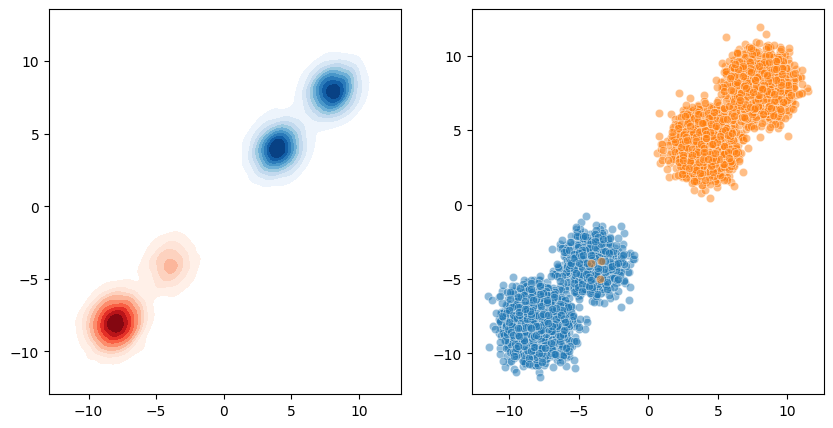

In [14]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
sns.kdeplot(x=noisy_labeled_pos[:,0], y=noisy_labeled_pos[:,1], cmap="Reds", fill=True, ax=ax[0])
sns.scatterplot(x=noisy_labeled_pos[:,0], y=noisy_labeled_pos[:,1], cmap="Reds", ax=ax[1],alpha=.5)
sns.kdeplot(x=noisy_labeled_neg[:,0], y=noisy_labeled_neg[:,1], cmap="Blues", fill=True, ax=ax[0])
sns.scatterplot(x=noisy_labeled_neg[:,0], y=noisy_labeled_neg[:,1], cmap="Blues", ax=ax[1],alpha=.5)


In [15]:
em = PNU_EM(n_components=2,max_steps=500)

In [16]:
em.fit(noisy_labeled_pos, noisy_labeled_neg,unlabeled_data,
        scores_labeled_pos=scores_labeled_pos,
        scores_labeled_neg=scores_labeled_neg)

Initial Parameters:
alpha: 0.3,

mu_pos: [[-4.0035 -3.9721]
 [-8.0605 -8.0321]],

cov_pos: [[[ 1.0588 -0.0165]
  [-0.0165  1.0023]]

 [[ 1.0462  0.0551]
  [ 0.0551  0.9428]]],

w_pos: [[0.749]
 [0.251]],

v_pos: [[0.7985]
 [0.2015]],

mu_neg: [[3.9988 4.0177]
 [7.9776 7.9908]],

cov_neg: [[[1.0126 0.0197]
  [0.0197 0.9822]]

 [[1.0247 0.0219]
  [0.0219 0.9627]]],

w_neg: [[0.3504]
 [0.6496]],

v_neg: [[0.4991]
 [0.5009]],



INFO:root:EM algorithm converged after 1 steps in 2.512458086013794 seconds.


Step 1 log-likelihood: -63164.677578631046
alpha: 0.3,

mu_pos: [[-4.0391 -4.0335]
 [-8.0299 -8.0264]],

cov_pos: [[[ 1.0781  0.0561]
  [ 0.0561  1.052 ]]

 [[ 0.9836 -0.0019]
  [-0.0019  0.9946]]],

w_pos: [[0.7496]
 [0.2504]],

v_pos: [[0.2044]
 [0.7956]],

mu_neg: [[3.9899 4.0028]
 [7.9965 7.9891]],

cov_neg: [[[0.9877 0.0041]
  [0.0041 0.9834]]

 [[1.0248 0.0122]
  [0.0122 0.9758]]],

w_neg: [[0.3495]
 [0.6505]],

v_neg: [[0.5002]
 [0.4998]],

